In [1]:
import xarray as xr
import sys
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy import signal
from matplotlib.offsetbox import AnnotationBbox
import seaborn as sb
%matplotlib inline

In [2]:
sys.path.append('/workspace/bkraft/dl_chapter14/src/')
from utils.plotting import plot_map, subplots_robinson, plot_hexbin, text_box, subplots_plateCarree
from utils.metrics import get_metrics

In [3]:
fig_width_pt = 443.57848                # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.                # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*golden_mean       # height in inches
fig_size = [fig_width,fig_height]

pgf_with_latex = {                      # setup matplotlib to use latex for output
    "pgf.texsystem": "xelatex",         # change this if using xetex or lautex
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": [],  # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": 9,                # LaTeX default is 10pt font.
    "axes.titlesize": 9,
    "font.size": 7,
    "legend.fontsize": 9,               # Make the legend/label fonts a little smaller
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "figure.figsize": fig_size,        # default fig size of 0.9 textwidth
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts becasue your computer can handle it :)
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        ],
    'axes.linewidth': 0.5,
    'xtick.major.width': 0.5,
    'xtick.minor.width': 0.5,
    'ytick.major.width': 0.5,
    'ytick.minor.width': 0.5
    }
mpl.rcParams.update(pgf_with_latex)

def new_subplots(nrow, ncol, wh_ratio, width=1, **kwargs):
    plt.clf()
    fig, ax = plt.subplots(nrow, ncol, figsize=fig_size, **kwargs)
    return fig, ax

def savefig(filename, **kwargs):
    #plt.savefig('{}.pgf'.format(filename), pad_inches = 0, bbox_inches='tight')
    plt.savefig('{}.pdf'.format(filename), pad_inches = 0.05, bbox_inches='tight', **kwargs)

/opt/conda/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [4]:
fig_size

[6.160812222222222, 3.8075913516391036]

Added some useful functions, I will add more (e.g. plotting time-eries). Please don't change source code. You can also just use your own stuff or copy my functions and change them, or let me know if you want to have something changed.

## Load Data

In [32]:
'/workspace/bkraft/dlchapter_backup/dl_chapter14/experiments/et/n_sm.n_perm/inference/pred_so.zarr/'

#Spatially optimized
dss_nn = xr.open_zarr('/workspace/bkraft/dlchapter_backup/dl_chapter14/experiments/et/n_sm.n_perm/inference/pred_so.zarr/') *  86400 # 1 kg/m2/s = 86400 mm/day
dss_wn = xr.open_zarr('/workspace/bkraft/dlchapter_backup/dl_chapter14/experiments/et/w_sm.n_perm/inference/pred_so.zarr/') *  86400
dss_nw = xr.open_zarr('/workspace/bkraft/dlchapter_backup/dl_chapter14/experiments/et/n_sm.w_perm/inference/pred_so.zarr/') *  86400
dss_ww = xr.open_zarr('/workspace/bkraft/dlchapter_backup/dl_chapter14/experiments/et/w_sm.w_perm/inference/pred_so.zarr/') *  86400

#Temporally optimized
dst_nn = xr.open_zarr('/workspace/bkraft/dlchapter_backup/dl_chapter14/experiments/et/n_sm.n_perm/inference/pred_to.zarr/') *  86400
dst_wn = xr.open_zarr('/workspace/bkraft/dlchapter_backup/dl_chapter14/experiments/et/w_sm.n_perm/inference/pred_to.zarr/') *  86400
dst_nw = xr.open_zarr('/workspace/bkraft/dlchapter_backup/dl_chapter14/experiments/et/n_sm.w_perm/inference/pred_to.zarr/') *  86400
dst_ww = xr.open_zarr('/workspace/bkraft/dlchapter_backup/dl_chapter14/experiments/et/w_sm.w_perm/inference/pred_to.zarr/') *  86400

## Subset for the amazon region

In [33]:
amazon_mask = xr.open_dataset("/workspace/BGI/scratch/sbesnard/amazon_mask_360_720.nc").sel(lat= slice(10,-22), lon= slice(-85, -40))
amazon_raw_nn = dst_nn.sel(lat= slice(10,-22), lon= slice(-85, -40)) * amazon_mask.amazon_boundary
amazon_raw_nw = dst_nw.sel(lat= slice(10,-22), lon= slice(-85, -40)) * amazon_mask.amazon_boundary
amazon_raw_wn = dst_wn.sel(lat= slice(10,-22), lon= slice(-85, -40)) * amazon_mask.amazon_boundary
amazon_raw_ww = dst_ww.sel(lat= slice(10,-22), lon= slice(-85, -40)) * amazon_mask.amazon_boundary

## Subset for Australia

In [34]:
australia_raw_nn = dst_nn.sel(lat= slice(-10,-40), lon= slice(109, 156))
australia_raw_nw = dst_nw.sel(lat= slice(-10,-40), lon= slice(109, 156))
australia_raw_wn = dst_wn.sel(lat= slice(-10,-40), lon= slice(109, 156))
australia_raw_ww = dst_ww.sel(lat= slice(-10,-40), lon= slice(109, 156))

## Compute monthly seasonal cycle

In [35]:
#Amazon
amazon_seas_obs = amazon_raw_wn.sel(time=slice('2001-01-01', '2013-12-31')).obs.mean(('lat', 'lon')).groupby('time.month').mean('time')
amazon_seas_wn = amazon_raw_wn.sel(time=slice('2001-01-01', '2013-12-31')).mod.mean(('lat', 'lon')).groupby('time.month').mean('time')
amazon_seas_nn = amazon_raw_nn.sel(time=slice('2001-01-01', '2013-12-31')).mod.mean(('lat', 'lon')).groupby('time.month').mean('time')
amazon_seas_ww = amazon_raw_ww.sel(time=slice('2001-01-01', '2013-12-31')).mod.mean(('lat', 'lon')).groupby('time.month').mean('time')
amazon_seas_nw = amazon_raw_nw.sel(time=slice('2001-01-01', '2013-12-31')).mod.mean(('lat', 'lon')).groupby('time.month').mean('time')

In [36]:
#Amazon
amazon_seas_obs_2005 = amazon_raw_wn.sel(time=slice('2005-01-01', '2005-12-31')).obs.mean(('lat', 'lon')).groupby('time.month').mean('time')
amazon_seas_wn_2005 = amazon_raw_wn.sel(time=slice('2005-01-01', '2005-12-31')).mod.mean(('lat', 'lon')).groupby('time.month').mean('time')
amazon_seas_nn_2005 = amazon_raw_nn.sel(time=slice('2005-01-01', '2005-12-31')).mod.mean(('lat', 'lon')).groupby('time.month').mean('time')
amazon_seas_ww_2005 = amazon_raw_ww.sel(time=slice('2005-01-01', '2005-12-31')).mod.mean(('lat', 'lon')).groupby('time.month').mean('time')
amazon_seas_nw_2005 = amazon_raw_nw.sel(time=slice('2005-01-01', '2005-12-31')).mod.mean(('lat', 'lon')).groupby('time.month').mean('time')

In [37]:
#Australia
australia_seas_obs = australia_raw_wn.sel(time=slice('2001-01-01', '2013-12-31')).obs.mean(('lat', 'lon')).groupby('time.month').mean('time')
australia_seas_wn = australia_raw_wn.sel(time=slice('2001-01-01', '2013-12-31')).mod.mean(('lat', 'lon')).groupby('time.month').mean('time')
australia_seas_nn = australia_raw_nn.sel(time=slice('2001-01-01', '2013-12-31')).mod.mean(('lat', 'lon')).groupby('time.month').mean('time')
australia_seas_ww = australia_raw_ww.sel(time=slice('2001-01-01', '2013-12-31')).mod.mean(('lat', 'lon')).groupby('time.month').mean('time')
australia_seas_nw = australia_raw_nw.sel(time=slice('2001-01-01', '2013-12-31')).mod.mean(('lat', 'lon')).groupby('time.month').mean('time')

In [38]:
#Australia
australia_seas_obs_2010 = australia_raw_wn.sel(time=slice('2010-01-01', '2010-12-31')).obs.mean(('lat', 'lon')).groupby('time.month').mean('time')
australia_seas_wn_2010 = australia_raw_wn.sel(time=slice('2010-01-01', '2010-12-31')).mod.mean(('lat', 'lon')).groupby('time.month').mean('time')
australia_seas_nn_2010 = australia_raw_nn.sel(time=slice('2010-01-01', '2010-12-31')).mod.mean(('lat', 'lon')).groupby('time.month').mean('time')
australia_seas_ww_2010 = australia_raw_ww.sel(time=slice('2010-01-01', '2010-12-31')).mod.mean(('lat', 'lon')).groupby('time.month').mean('time')
australia_seas_nw_2010 = australia_raw_nw.sel(time=slice('2010-01-01', '2010-12-31')).mod.mean(('lat', 'lon')).groupby('time.month').mean('time')

## Compute the residuals of the mean seasonal variations

In [39]:
# Amazon
amazon_seas_var_res_wn = (amazon_seas_obs - amazon_seas_obs.mean('month')) - (amazon_seas_wn - amazon_seas_wn.mean('month')) 
amazon_seas_var_res_nn = (amazon_seas_obs - amazon_seas_obs.mean('month')) - (amazon_seas_nn - amazon_seas_nn.mean('month')) 
amazon_seas_var_res_nw = (amazon_seas_obs - amazon_seas_obs.mean('month')) - (amazon_seas_nw - amazon_seas_nw.mean('month')) 
amazon_seas_var_res_ww = (amazon_seas_obs - amazon_seas_obs.mean('month')) - (amazon_seas_ww - amazon_seas_ww.mean('month')) 

In [40]:
# Australia
australia_seas_var_res_wn = (australia_seas_obs - australia_seas_obs.mean('month')) - (australia_seas_wn - australia_seas_wn.mean('month')) 
australia_seas_var_res_nn = (australia_seas_obs - australia_seas_obs.mean('month')) - (australia_seas_nn - australia_seas_nn.mean('month')) 
australia_seas_var_res_nw = (australia_seas_obs - australia_seas_obs.mean('month')) - (australia_seas_nw - australia_seas_nw.mean('month')) 
australia_seas_var_res_ww = (australia_seas_obs - australia_seas_obs.mean('month')) - (australia_seas_ww - australia_seas_ww.mean('month')) 

## Compute monthly anomalies

In [41]:
##Amazon

#Compute monthly mean 2000-2013
amazon_seas_obs = amazon_raw_wn.obs.mean(('lat', 'lon')).groupby('time.month').mean('time')
amazon_seas_wn = amazon_raw_wn.mod.mean(('lat', 'lon')).groupby('time.month').mean('time')
amazon_seas_nn = amazon_raw_nn.mod.mean(('lat', 'lon')).groupby('time.month').mean('time')
amazon_seas_ww = amazon_raw_ww.mod.mean(('lat', 'lon')).groupby('time.month').mean('time')
amazon_seas_nw = amazon_raw_nw.mod.mean(('lat', 'lon')).groupby('time.month').mean('time')

# Compute montly mean for 2005
amazon_seas_obs_2005 = amazon_raw_wn.obs.mean(('lat', 'lon')).resample(time = '1MS').mean().sel(time=slice('2005-01-01', '2005-12-31'))
amazon_seas_wn_2005 = amazon_raw_wn.mod.mean(('lat', 'lon')).resample(time = '1MS').mean().sel(time=slice('2005-01-01', '2005-12-31'))
amazon_seas_nn_2005 = amazon_raw_nn.mod.mean(('lat', 'lon')).resample(time = '1MS').mean().sel(time=slice('2005-01-01', '2005-12-31'))
amazon_seas_nw_2005 = amazon_raw_nw.mod.mean(('lat', 'lon')).resample(time = '1MS').mean().sel(time=slice('2005-01-01', '2005-12-31'))
amazon_seas_ww_2005 = amazon_raw_ww.mod.mean(('lat', 'lon')).resample(time = '1MS').mean().sel(time=slice('2005-01-01', '2005-12-31'))

# Compute montly anomalies
amazon_anom_obs_2005 = amazon_seas_obs_2005.values - amazon_seas_obs.values
amazon_anom_wn_2005 = amazon_seas_wn_2005.values - amazon_seas_wn.values
amazon_anom_nn_2005 = amazon_seas_nn_2005.values - amazon_seas_nn.values
amazon_anom_ww_2005 = amazon_seas_ww_2005.values - amazon_seas_ww.values
amazon_anom_nw_2005 = amazon_seas_nw_2005.values - amazon_seas_nw.values

In [42]:
##Amazon

#Compute monthly mean 2000-2013
australia_seas_obs = australia_raw_wn.obs.mean(('lat', 'lon')).groupby('time.month').mean('time')
australia_seas_wn = australia_raw_wn.mod.mean(('lat', 'lon')).groupby('time.month').mean('time')
australia_seas_nn = australia_raw_nn.mod.mean(('lat', 'lon')).groupby('time.month').mean('time')
australia_seas_ww = australia_raw_ww.mod.mean(('lat', 'lon')).groupby('time.month').mean('time')
australia_seas_nw = australia_raw_nw.mod.mean(('lat', 'lon')).groupby('time.month').mean('time')

# Compute montly mean for 2010
australia_seas_obs_2010 = australia_raw_wn.obs.mean(('lat', 'lon')).resample(time = '1MS').mean().sel(time=slice('2010-01-01', '2010-12-31'))
australia_seas_wn_2010 = australia_raw_wn.mod.mean(('lat', 'lon')).resample(time = '1MS').mean().sel(time=slice('2010-01-01', '2010-12-31'))
australia_seas_nn_2010 = australia_raw_nn.mod.mean(('lat', 'lon')).resample(time = '1MS').mean().sel(time=slice('2010-01-01', '2010-12-31'))
australia_seas_nw_2010 = australia_raw_nw.mod.mean(('lat', 'lon')).resample(time = '1MS').mean().sel(time=slice('2010-01-01', '2010-12-31'))
australia_seas_ww_2010 = australia_raw_ww.mod.mean(('lat', 'lon')).resample(time = '1MS').mean().sel(time=slice('2010-01-01', '2010-12-31'))

# Compute montly anomalies
australia_anom_obs_2010 = australia_seas_obs_2010.values - australia_seas_obs.values
australia_anom_wn_2010 = australia_seas_wn_2010.values - australia_seas_wn.values
australia_anom_nn_2010 = australia_seas_nn_2010.values - australia_seas_nn.values
australia_anom_ww_2010 = australia_seas_ww_2010.values - australia_seas_ww.values
australia_anom_nw_2010 = australia_seas_nw_2010.values - australia_seas_nw.values

## Compute annual anomalies (z-score)

In [43]:
##Amazon

# No permutation with soil moisture
amazon_raw_wn_annual = amazon_raw_wn.groupby('time.year').mean('time')
amazon_raw_wn_std = amazon_raw_wn.groupby('time.year').mean('time').std('year')
amazon_raw_wn_mean = amazon_raw_wn.groupby('time.year').mean('time').mean('year')
amazon_raw_wn_anomaly_standarise = (amazon_raw_wn_annual - amazon_raw_wn_mean) / amazon_raw_wn_std
amazon_raw_obs_anomaly_standarise_detrend = signal.detrend(amazon_raw_wn_anomaly_standarise.obs.mean(('lat', 'lon')))
amazon_raw_wn_anomaly_standarise_detrend = signal.detrend(amazon_raw_wn_anomaly_standarise.mod.mean(('lat', 'lon')))

# No permutation no soil moisture
amazon_raw_nn_annual = amazon_raw_nn.groupby('time.year').mean('time')
amazon_raw_nn_std = amazon_raw_nn.groupby('time.year').mean('time').std('year')
amazon_raw_nn_mean = amazon_raw_nn.groupby('time.year').mean('time').mean('year')
amazon_raw_nn_anomaly_standarise = (amazon_raw_nn_annual - amazon_raw_nn_mean) / amazon_raw_nn_std
amazon_raw_nn_anomaly_standarise_detrend = signal.detrend(amazon_raw_nn_anomaly_standarise.mod.mean(('lat', 'lon')))

# Permutation with soil moisture
amazon_raw_ww_annual = amazon_raw_ww.groupby('time.year').mean('time')
amazon_raw_ww_std = amazon_raw_ww.groupby('time.year').mean('time').std('year')
amazon_raw_ww_mean = amazon_raw_ww.groupby('time.year').mean('time').mean('year')
amazon_raw_ww_anomaly_standarise = (amazon_raw_ww_annual - amazon_raw_ww_mean) / amazon_raw_ww_std
amazon_raw_ww_anomaly_standarise_detrend = signal.detrend(amazon_raw_ww_anomaly_standarise.mod.mean(('lat', 'lon')))

# Permutation no soil moisture
amazon_raw_nw_annual = amazon_raw_nw.groupby('time.year').mean('time')
amazon_raw_nw_std = amazon_raw_nw.groupby('time.year').mean('time').std('year')
amazon_raw_nw_mean = amazon_raw_nw.groupby('time.year').mean('time').mean('year')
amazon_raw_nw_anomaly_standarise = (amazon_raw_nw_annual - amazon_raw_nw_mean) / amazon_raw_nw_std
amazon_raw_nw_anomaly_standarise_detrend = signal.detrend(amazon_raw_nw_anomaly_standarise.mod.mean(('lat', 'lon')))

/opt/conda/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [44]:
##Australia

# No permutation with soil moisture
australia_raw_wn_annual = australia_raw_wn.groupby('time.year').mean('time')
australia_raw_wn_std = australia_raw_wn.groupby('time.year').mean('time').std('year')
australia_raw_wn_mean = australia_raw_wn.groupby('time.year').mean('time').mean('year')
australia_raw_wn_anomaly_standarise = (australia_raw_wn_annual - australia_raw_wn_mean) / australia_raw_wn_std
australia_raw_obs_anomaly_standarise_detrend = signal.detrend(australia_raw_wn_anomaly_standarise.obs.mean(('lat', 'lon')))
australia_raw_wn_anomaly_standarise_detrend = signal.detrend(australia_raw_wn_anomaly_standarise.mod.mean(('lat', 'lon')))

# No permutation no soil moisture
australia_raw_nn_annual = australia_raw_nn.groupby('time.year').mean('time')
australia_raw_nn_std = australia_raw_nn.groupby('time.year').mean('time').std('year')
australia_raw_nn_mean = australia_raw_nn.groupby('time.year').mean('time').mean('year')
australia_raw_nn_anomaly_standarise = (australia_raw_nn_annual - australia_raw_nn_mean) / australia_raw_nn_std
australia_raw_nn_anomaly_standarise_detrend = signal.detrend(australia_raw_nn_anomaly_standarise.mod.mean(('lat', 'lon')))

# Permutation with soil moisture
australia_raw_ww_annual = australia_raw_ww.groupby('time.year').mean('time')
australia_raw_ww_std = australia_raw_ww.groupby('time.year').mean('time').std('year')
australia_raw_ww_mean = australia_raw_ww.groupby('time.year').mean('time').mean('year')
australia_raw_ww_anomaly_standarise = (australia_raw_ww_annual - australia_raw_ww_mean) / australia_raw_ww_std
australia_raw_ww_anomaly_standarise_detrend = signal.detrend(australia_raw_ww_anomaly_standarise.mod.mean(('lat', 'lon')))

# Permutation no soil moisture
australia_raw_nw_annual = australia_raw_nw.groupby('time.year').mean('time')
australia_raw_nw_std = australia_raw_nw.groupby('time.year').mean('time').std('year')
australia_raw_nw_mean = australia_raw_nw.groupby('time.year').mean('time').mean('year')
australia_raw_nw_anomaly_standarise = (australia_raw_nw_annual - australia_raw_nw_mean) / australia_raw_nw_std
australia_raw_nw_anomaly_standarise_detrend = signal.detrend(australia_raw_nw_anomaly_standarise.mod.mean(('lat', 'lon')))

/opt/conda/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


## Combine different scale into one numpy array

In [45]:
#Amazon
amazon_obs = {"mean_seasonal_cycle": amazon_seas_obs, 'seasonal_anomaly':amazon_anom_obs_2005,
             "seasonal_res":np.zeros(10), 'annual_anomaly':amazon_raw_obs_anomaly_standarise_detrend}
amazon_wn = {"mean_seasonal_cycle": amazon_seas_wn, 'seasonal_anomaly':amazon_anom_wn_2005,
             "seasonal_res":amazon_seas_var_res_wn, 'annual_anomaly':amazon_raw_wn_anomaly_standarise_detrend}
amazon_nn = {"mean_seasonal_cycle": amazon_seas_nn, 'seasonal_anomaly':amazon_anom_nn_2005,
             "seasonal_res":amazon_seas_var_res_nn, 'annual__nomaly':amazon_raw_nn_anomaly_standarise_detrend}
amazon_ww = {"mean_seasonal_cycle": amazon_seas_ww, 'seasonal_anomaly':amazon_anom_ww_2005,
             "seasonal_res":amazon_seas_var_res_ww, 'annual_anomaly':amazon_raw_ww_anomaly_standarise_detrend}
amazon_nw = {"mean_seasonal_cycle": amazon_seas_nw, 'seasonal_anomaly':amazon_anom_nw_2005,
             "seasonal_res":amazon_seas_var_res_nw, 'annual_anomaly':amazon_raw_nw_anomaly_standarise_detrend}

In [46]:
#australia
australia_obs = {"mean_seasonal_cycle": australia_seas_obs_2010, 'seasonal_anomaly':australia_anom_obs_2010,
             "seasonal_res":np.zeros(10), 'annual_anomaly':australia_raw_obs_anomaly_standarise_detrend}
australia_wn = {"mean_seasonal_cycle": australia_seas_wn_2010, 'seasonal_anomaly':australia_anom_wn_2010,
             "seasonal_res":australia_seas_var_res_wn, 'annual_anomaly':australia_raw_wn_anomaly_standarise_detrend}
australia_nn = {"mean_seasonal_cycle": australia_seas_nn_2010, 'seasonal_anomaly':australia_anom_nn_2010,
             "seasonal_res":australia_seas_var_res_nn, 'annual_anomaly':australia_raw_nn_anomaly_standarise_detrend}
australia_ww = {"mean_seasonal_cycle": australia_seas_ww_2010, 'seasonal_anomaly':australia_anom_ww_2010,
             "seasonal_res":australia_seas_var_res_ww, 'annual_anomaly':australia_raw_ww_anomaly_standarise_detrend}
australia_nw = {"mean_seasonal_cycle": australia_seas_nw_2010, 'seasonal_anomaly':australia_anom_nw_2010,
             "seasonal_res":australia_seas_var_res_nw, 'annual_anomaly':australia_raw_nw_anomaly_standarise_detrend}

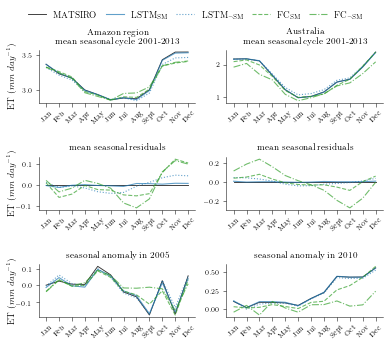

In [49]:
fig, ax = plt.subplots(3, 2, figsize=(fig_size[0], fig_size[0]*0.8), gridspec_kw={'wspace': 0.2, 'hspace': 1})



def get_style(style, i):
    legend = i == 0
    alpha = 0.7
    linewidth = 1.1
    style0 = dict(
        color='0.2',
        linestyle='solid',
        linewidth=0.9,
        alpha=1,
        label='MATSIRO' if legend else '_nolegend_',
    )
    style1 = dict(
        linewidth=linewidth,
        linestyle='solid',
        color=sb.color_palette("Paired")[1],
        alpha=alpha,
        label=r'$\mathrm{LSTM_{SM}}$' if legend else '_nolegend_'
    )
    style2 = dict(
        linewidth=linewidth,
        linestyle='dotted',
        color=sb.color_palette("Paired")[1],
        alpha=alpha,
        label=r'$\mathrm{LSTM_{\neg SM}}$' if legend else '_nolegend_'
    )
    style3 = dict(
        linewidth=linewidth,
        linestyle='dashed',
        color=sb.color_palette("Paired")[3],
        alpha=alpha,
        label=r'$\mathrm{FC_{SM}}$' if legend else '_nolegend_'
    )
    style4 = dict(
        linewidth=linewidth,
        linestyle='dashdot',
        color=sb.color_palette("Paired")[3],
        alpha=alpha,
        label=r'$\mathrm{FC_{\neg SM}}$' if legend else '_nolegend_'
    )
    return [style0, style1, style2, style3, style4][style]

for i, var in enumerate(['mean_seasonal_cycle', 'seasonal_res', 'seasonal_anomaly']):

    if var in ['seasonal_res']:
        # Amazon
        # ax[i, 0].axhline(y=0, xmin=-0.11692960554993577, xmax=0.13768228649736652, **get_style(0, i))
        ax[i, 0].plot([0, 11], [0, 0], **get_style(0, i))
        
        # Australia
        ax[i, 1].plot([0, 11], [0, 0], **get_style(0, i))
        
    else:
        # Amazon
        ax[i, 0].plot(amazon_obs[var], **get_style(0, i))

        # Australia
        ax[i, 1].plot(australia_obs[var], **get_style(0, i))

    ax[i, 0].plot(amazon_wn[var], **get_style(1, i))
    ax[i, 0].plot(amazon_nn[var], **get_style(2, i))
    ax[i, 0].plot(amazon_ww[var], **get_style(3, i))
    ax[i, 0].plot(amazon_nw[var], **get_style(4, i))
    ax[i, 0].spines['top'].set_visible(False)
    ax[i, 0].spines['right'].set_visible(False)

    ax[i, 1].plot(australia_wn[var], **get_style(1, i))
    ax[i, 1].plot(australia_nn[var], **get_style(2, i))
    ax[i, 1].plot(australia_ww[var], **get_style(3, i))
    ax[i, 1].plot(australia_nw[var], **get_style(4, i))
    ax[i, 1].spines['top'].set_visible(False)
    ax[i, 1].spines['right'].set_visible(False)



    ax[i, 0].set_ylabel('ET ($mm \ day^{-1}$)')
    ax[i, 1].set_ylabel('')
    ax[i, 0].set_xticks(np.arange(0, 12))
    ax[i, 0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec'],
               rotation=45)
    ax[i, 1].set_xticks(np.arange(0, 12))
    ax[i, 1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec'],
               rotation=45)
    ax[i, 0].yaxis.set_label_coords(-0.14, 0.5)
ax[0, 0].set_title('Amazon region\n mean seasonal cycle 2001-2013')
ax[0, 1].set_title('Australia\n mean seasonal cycle 2001-2013')
ax[1, 0].set_title('mean seasonal residuals')
ax[1, 1].set_title('mean seasonal residuals')
ax[2, 0].set_title('seasonal anomaly in 2005')
ax[2, 1].set_title('seasonal anomaly in 2010')

#ax[-2, 1].legend();
ax[0, 0].legend(loc='upper center', bbox_to_anchor=(1., 1.8),
          ncol=5, frameon=False, labelspacing=-1, borderaxespad=0., columnspacing=1)
plt.gca().yaxis.set_label_position("right")

savefig('/workspace/bkraft/dl_chapter14/src/notebooks/exp2_figures/Fig5', dpi=300)

## Compute difference of the annual anomalies

In [118]:
#Amazon
amazon_diff_obs_wn = amazon_raw_wn_anomaly_standarise.sel(year=2005).obs - amazon_raw_wn_anomaly_standarise.sel(year=2005).mod
amazon_diff_obs_wn.to_netcdf('/workspace/bkraft/dl_chapter14/src/amazon_diff_obs_wn.nc')
amazon_diff_obs_nn = amazon_raw_wn_anomaly_standarise.sel(year=2005).obs - amazon_raw_nn_anomaly_standarise.sel(year=2005).mod
amazon_diff_obs_nn.to_netcdf('/workspace/bkraft/dl_chapter14/src/amazon_diff_obs_nn.nc')
amazon_diff_obs_ww = amazon_raw_wn_anomaly_standarise.sel(year=2005).obs - amazon_raw_ww_anomaly_standarise.sel(year=2005).mod
amazon_diff_obs_ww.to_netcdf('/workspace/bkraft/dl_chapter14/src/amazon_diff_obs_ww.nc')
amazon_diff_obs_nw = amazon_raw_wn_anomaly_standarise.sel(year=2005).obs - amazon_raw_nw_anomaly_standarise.sel(year=2005).mod
amazon_diff_obs_nw.to_netcdf('/workspace/bkraft/dl_chapter14/src/amazon_diff_obs_nw.nc')


/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [123]:
#australia
australia_diff_obs_wn = australia_raw_wn_anomaly_standarise.sel(year=2010).obs - australia_raw_wn_anomaly_standarise.sel(year=2010).mod
australia_diff_obs_wn.to_netcdf('/workspace/bkraft/dl_chapter14/src/australia_diff_obs_wn.nc')
australia_diff_obs_nn = australia_raw_wn_anomaly_standarise.sel(year=2010).obs - australia_raw_nn_anomaly_standarise.sel(year=2010).mod
australia_diff_obs_nn.to_netcdf('/workspace/bkraft/dl_chapter14/src/australia_diff_obs_nn.nc')
australia_diff_obs_ww = australia_raw_wn_anomaly_standarise.sel(year=2010).obs - australia_raw_ww_anomaly_standarise.sel(year=2010).mod
australia_diff_obs_ww.to_netcdf('/workspace/bkraft/dl_chapter14/src/australia_diff_obs_ww.nc')
australia_diff_obs_nw = australia_raw_wn_anomaly_standarise.sel(year=2010).obs - australia_raw_nw_anomaly_standarise.sel(year=2010).mod
australia_diff_obs_nw.to_netcdf('/workspace/bkraft/dl_chapter14/src/australia_diff_obs_nw.nc')


/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


## Scatterplot LSTM vs MATSIRO annual anomalies

/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.p

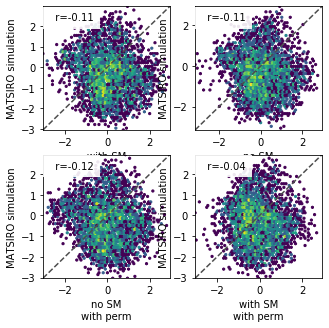

In [236]:
fig, ax = plt.subplots(2, 2, figsize=(5, 5))
plot_hexbin(amazon_raw_wn_anomaly_standarise.sel(year = 2005).mod, amazon_raw_wn_anomaly_standarise.sel(year = 2005).obs, 
           xlabel= 'with SM\nno perm', ylabel= 'MATSIRO simulation', ax=ax[0,0])
plot_hexbin(amazon_raw_nn_anomaly_standarise.sel(year = 2005).mod, amazon_raw_nn_anomaly_standarise.sel(year = 2005).obs, 
           xlabel= 'no SM\nno perm', ylabel= 'MATSIRO simulation', ax=ax[0,1])
plot_hexbin(amazon_raw_ww_anomaly_standarise.sel(year = 2005).mod, amazon_raw_nw_anomaly_standarise.sel(year = 2005).obs, 
           xlabel= 'no SM\nwith perm', ylabel= 'MATSIRO simulation', ax=ax[1,0])
plot_hexbin(amazon_raw_nw_anomaly_standarise.sel(year = 2005).mod, amazon_raw_ww_anomaly_standarise.sel(year = 2005).obs, 
           xlabel= 'with SM\nwith perm', ylabel= 'MATSIRO simulation', ax=ax[1,1])
plt.savefig('/workspace/bkraft/dl_chapter14/src/notebooks/exp2_figures/annual_anomaly_amazon_scatter.png', dpi=300)

## Plot Difference maps

[0.5, 0.4, 0.3, 0.2, 0.1, -0.1]

In [49]:
np.linspace(0, 0.3, 11)

array([0.  , 0.03, 0.06, 0.09, 0.12, 0.15, 0.18, 0.21, 0.24, 0.27, 0.3 ])

/workspace/bkraft/dl_chapter14/src/utils/plotting.py:168: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axh.set_yticks([], [])
<ipython-input-52-8ea037d9c69a>:30: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_linewidth(0.5)
/workspace/bkraft/dl_chapter14/src/utils/plotting.py:168: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axh.set_yticks([], [])
<ipython-input-52-8ea037d9c69a>:30: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_linewidth(0.5)
/workspace/bkraft/dl_chapter14/src/utils/plotting.py:168

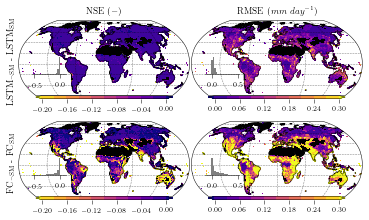

In [52]:
metrics = xr.open_dataset('/workspace/bkraft/dlchapter_backup/dl_chapter14/experiments/et/derived/spatial_metrics.nc')
fig, axes = subplots_robinson(2, 2, figsize=(fig_size[0], fig_size[0]*0.6), gridspec_kw={'wspace': 0.01, 'hspace': 0.01})

for i, met in enumerate(['mef', 'rmse']):
    
    for j, (mod, mod_name) in enumerate(zip(['wn_nn', 'ww_nw'], [r'$\mathrm{LSTM_{\neg SM}}$ - $\mathrm{LSTM_{SM}}$', r'$\mathrm{FC_{\neg SM}}$ - $\mathrm{FC_{SM}}$'])):

        ax = axes[j, i]
        if mod == 'wn_nn':
            dt = metrics[met].sel(model= 'nn', timeres='daily', set='raw', cvset='eval') - metrics[met].sel(model= 'wn', timeres='daily', set='raw', cvset='eval')
        else:
            dt = metrics[met].sel(model= 'nw', timeres='daily', set='raw', cvset='eval') - metrics[met].sel(model= 'ww', timeres='daily', set='raw', cvset='eval')
        label = 'NSE ($-$)' if met=='mef' else 'RMSE ($mm \ day^{-1}$)'
#         plot_map(
#             dt, label=' ',
#             vmin=-0.5 if met=='mef' else 0.0, vmax=0.0 if met=='mef' else 0.5,
#             cmap='plasma_r' if met=='mef' else 'Blues', ax=ax,
#             histogram_placement=[0.08, 0.28, 0.2, 0.25], hist_kw={'bins': 20, 'edgecolor': 'none'}, cbar_kwargs={'extend': 'both'}, landcolor='0.0') # [x0, y0, width, height]
        plot_map(
            dt, label=' ',
            levels=np.linspace(-0.2, 0, 11) if met == 'mef' else np.linspace(0, 0.3, 11),
            vmin=-0.5 if met=='mef' else -0.1, vmax=0.1 if met=='mef' else 0.5,
            cmap='plasma_r' if met=='mef' else 'plasma', ax=ax,
            histogram_placement=[0.08, 0.28, 0.2, 0.25], hist_kw={'bins': 20, 'edgecolor': 'none'}, cbar_kwargs={'extend': 'both'}, landcolor='0.0', contourf=True) # [x0, y0, width, height]
        ax.set_title('')
        if i == 0:
            ax.text(-0.02, 0.45, mod_name, horizontalalignment='right', verticalalignment='center', transform=ax.transAxes, rotation=90, size=9)
        if j == 0:
            ax.set_title(label, size=9)
        ax.outline_patch.set_linewidth(0.5)

savefig('/workspace/bkraft/dl_chapter14/src/notebooks/exp2_figures/Fig3', dpi=300)